# CS771A Assignment 4
\- Yash Gupta (190997)

Use any additional libraries you want, but if you don't explicitly code stuff that I have explicitly asked you to code, you will not get marks.

### Q1. Kernel k-means

Let's try and end our course on a happy note. The smiley dataset you see below is made up of many clusters of points. 

In [2]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt


def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

In [3]:
d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
X = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

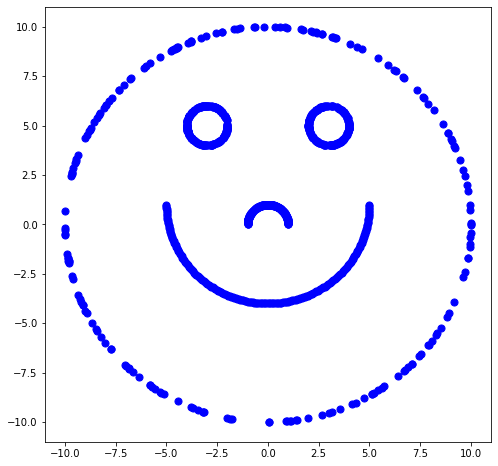

In [4]:
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = 'b', marker = 'o' )

(a) Can you implement the k-means algorithm to cluster this dataset? Visualize your output. [10 points] 

In [50]:
def kmeans(X, K=4, max_iter=100000):
    N = X.shape[0]
    dim = X.shape[1]
    z = np.zeros(N)
    mu = rnd.rand(K, dim)
    t = 0
    while t < max_iter:
        mu_old = mu
        for n in range(N):
            min_dist = float('inf')
            for k in range(K):
                dist = lin.norm(X[n] - mu[k], 2)
                if dist < min_dist:
                    z[n] = k
                    min_dist = dist
        
        for k in range(K):
            sum = np.zeros(dim)
            num = 0
            for n in range(N):
                if z[n] == k:
                    num += 1
                    sum += X[n]
            mu[k] = sum / num if num else mu_old[k]
        if (mu_old == mu).sum() == K * dim:
            break
    return z

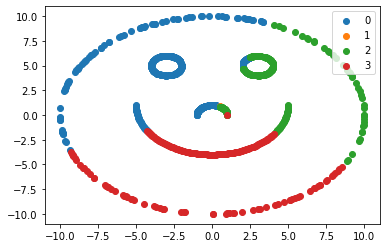

In [52]:
K = 4
z = kmeans(X, K)
for k in range(K):
    plt.scatter(X[z == k, 0], X[z == k, 1], label=k)
plt.legend()
plt.show()

(b) Implement k-means++ to initialize cluster centers usefully. [5 points]

In [77]:
def init_means(X, K):
    N = X.shape[0]
    dim = X.shape[1]
    selected = np.zeros(N)
    mu = rnd.rand(K, dim)
    idx = rnd.randint(N)
    mu[0] = X[idx]
    selected[idx] = 1
    for k in range(1, K):
        D = np.full(N, np.inf)
        D[selected == 1] = 0
        for n in range(N):
            if not selected[n]:
                for i in range(k):
                    dist = lin.norm(X[n] - mu[i], 2)
                    D[n] = min(D[n], dist)
        p = D ** 2
        p /= p.sum()
        idx = rnd.choice(N, p=p)
        mu[k] = X[idx]
        selected[idx] = 1
    return mu

def kmeans_plusplus(X, K=4, max_iter=100000):
    N = X.shape[0]
    dim = X.shape[1]
    z = np.zeros(N)
    mu = init_means(X, K)
    t = 0
    while t < max_iter:
        mu_old = mu
        for n in range(N):
            min_dist = float('inf')
            for k in range(K):
                dist = lin.norm(X[n] - mu[k], 2)
                if dist < min_dist:
                    z[n] = k
                    min_dist = dist
        
        for k in range(K):
            sum = np.zeros(dim)
            num = 0
            for n in range(N):
                if z[n] == k:
                    num += 1
                    sum += X[n]
            mu[k] = sum / num if num else mu_old[k]
        if (mu_old == mu).sum() == K * dim:
            break
    return z

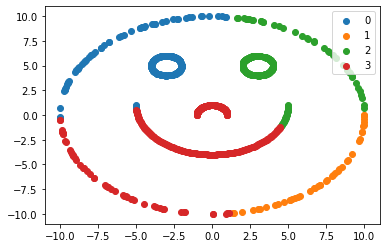

In [84]:
K = 4
z = kmeans_plusplus(X, K)
for k in range(K):
    plt.scatter(X[z == k, 0], X[z == k, 1], label=k)
plt.legend()
plt.show()

(c) What value of k gives you the best clustering? Are you happy with the quality of the clustering? [5 points]

(d) I'm going to say that we want to be able to do better than this. So I want you to kernelize your k-means algorithm with a Gaussian kernel. Visualize the clustering output of your kernel k-means algorithm [15 points]

In [108]:
def gaussian_kernel(x, z, gamma=1):
    dist = lin.norm(x - z, 2)
    exp = -gamma * dist ** 2
    kernel = np.exp(exp)
    return kernel

def init_means_kernel(X, K):
    N = X.shape[0]
    dim = X.shape[1]
    selected = np.zeros(N)
    mu = rnd.rand(K, dim)
    idx = rnd.randint(N)
    mu[0] = X[idx]
    selected[idx] = 1
    for k in range(1, K):
        D = np.full(N, np.inf)
        D[selected == 1] = 0
        for n in range(N):
            if not selected[n]:
                for i in range(k):
                    dist = gaussian_kernel(X[n], mu[i])
                    D[n] = min(D[n], dist)
        p = D ** 2
        p /= p.sum()
        idx = rnd.choice(N, p=p)
        mu[k] = X[idx]
        selected[idx] = 1
    return mu

def kmeans_plusplus_kernel(X, K=4, max_iter=100000):
    N = X.shape[0]
    dim = X.shape[1]
    z = np.zeros(N)
    mu = init_means(X, K)
    t = 0
    while t < max_iter:
        mu_old = mu
        for n in range(N):
            min_dist = float('inf')
            for k in range(K):
                dist = gaussian_kernel(X[n], mu[k])
                if dist < min_dist:
                    z[n] = k
                    min_dist = dist
        
        for k in range(K):
            sum = np.zeros(dim)
            num = 0
            for n in range(N):
                if z[n] == k:
                    num += 1
                    sum += X[n]
            mu[k] = sum / num if num else mu_old[k]
        if (mu_old == mu).sum() == K * dim:
            break
    return z

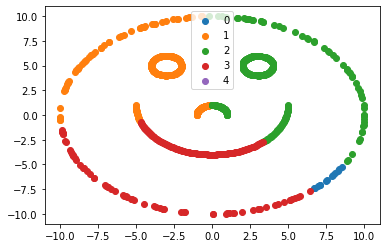

In [115]:
K = 5
z = kmeans_plusplus_kernel(X, K)
for k in range(K):
    plt.scatter(X[z == k, 0], X[z == k, 1], label=k)
plt.legend()
plt.show()

### Q2. Expectation-Maximization

We saw how to use EM to learn parameters for Gaussian mixture models last week. Specifically, for a GMM described by the set of parameters $\{\pi_k, \mu_k, \Sigma_k \}_{k=1}^K$, we saw that the E-step boils down to figuring out the expected assignment of clusters based on a responsibility judgment proportional to $\pi_k~N(\mu_k, \Sigma_k)$, given curent parameter estimates, followed by using GDA MLE updates assuming the current expected assignment in the M-step to update parameter values.

(a) Can you derive the E-step and M-step for an EM algorithm that would work for a Gaussian mixture model wherein the mixture weights $\pi_k$ are known, and the covariances are restricted to be spherical, i.e. $\Sigma_k = \sigma^2_k I$? [20 points]

(b) Implement this algorithm and show that it works on synthetic data with 3 clusters. If you are unable to derive the EM algorithm for part (a), implement the EM algorithm I showed in the class slides for the standard GMM (5 point penalty for taking this option) [15 points]. 